# Setting

## Import Module and Data

In [264]:
from datetime import datetime
from ast import literal_eval
from functools import reduce
from subprocess import call

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

from matplotlib import pyplot as plt
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier #decisio

import warnings
warnings.filterwarnings('ignore')

In [265]:
# import dataset
data = pd.read_excel('gd_dataset_apr/data.xlsx')
data['ym'] = data['ym'].astype(str)
data.drop('Unnamed: 0',axis='columns',inplace=True) 
col_o = list(data.columns)
col = ['date_a', 'date_c', 'year_c', 'quarter_c', 'status', 'headline', 'l1',
       'l2', 'l3', 'l4', 'acquirer', 'issuer', 'value', 'brief', 'advisor_f',
       'advisor_l', 'region', 'country', 'asset', 'num_asset',
       'upfront_payment', 'upfront_payment_cash', 'upfront_payment_equity',
       'milestone_payment', 'royalty_min', 'royalty_max', 'premium', 'stake',
       'share_price_1_', 'share_price_30_', 'offer price', 'num_security',
       'type_security', 'maturity_date', 'round', 'interest', 'maturity',
       'share_price_1', 'share_price_30', 'id', 'tag_lst', 'covid', 'drug',
       'therapy_area', 'indication', 'molecule_type',
       'geography', 'stage', 'route',
       'target', 'mechanism', 'classification', 'num_drug',
       'deal_stage', 'lead_drug', 'company_a',
       'hq_a', 'entity_a', 'company_i',
       'hq_i', 'entity_i', 'month', 'year', 'ym', 'n',
       'n_18', 'growth', 'l3_n', 'l3_n_18', 'l3_growth']
col_n = ['date_a', 'date_c', 'year_c', 'quarter_c', 'status', 'headline', 'l1',
       'l2', 'l3', 'l4', 'acquirer', 'issuer', 'value', 'brief', 'advisor_f',
       'advisor_l', 'region', 'country', 'round', 'id', 'tag_lst', 'covid', 'drug',
       'therapy_area', 'indication', 'molecule_type','geography', 'stage', 'route',
       'target', 'mechanism', 'classification', 'num_drug', 'deal_stage', 'lead_drug', 'company_a',
       'hq_a', 'entity_a', 'company_i', 'hq_i', 'entity_i', 'month', 'year', 'ym', 'n',
       'n_18', 'growth', 'l3_n', 'l3_n_18', 'l3_growth']
col_d = {}
for i in range(len(col)):
    col_d[col_o[i]] = col[i]
data.rename(columns=col_d, inplace=True)

data = data[col_n]
data = data.drop_duplicates(subset=['headline'])

In [266]:
# time variable
data['yr'] = [i[:4] for i in data['ym']]
data['yq'] = [i[:4]+'0'+str(1+(int(i)%100)//4) for i in data['ym']]
# drop duplicated deals
data = data.sort_values('value')
try_1 = data[data['l1']=="Capital Raisings"].drop_duplicates(subset=['ym','issuer'], keep='last')
try_2 = data[data['l1']!="Capital Raisings"]
data = try_1.append(try_2, ignore_index=True)
data = data.sort_values('ym')
# replace with new l3 entries
data_new_round = pd.read_csv('vc_stage.csv')
data_new_round = data_new_round[['headline','l3_new']]
data = data.merge(data_new_round, how='left', on='headline')
data['l3_new'] = data['l3_new'].apply(lambda d: d if isinstance(d,str) else "")
data['l3'] = np.where(data['l3_new'] != "", data['l3_new'], data['l3'])
data.loc[data.l3 == 'Growth Capital/Expansion', 'l3'] = 'Growth Capital'
data['vc_later'] = data['l3'].apply(lambda x: 1 if ((x=="Later Stage") or (x=="Growth Capital")) else 0)

In [267]:
data.head()

,date_a,date_c,year_c,quarter_c,status,headline,l1,l2,l3,l4,...,n,n_18,growth,l3_n,l3_n_18,l3_growth,yr,yq,l3_new,vc_later
0,2018-01-31,2018-01-31,2018.0,Q1,Completed,Magenta Therapeutics Enters into Agreement wit...,Strategic Alliances,Partnerships,Co-Development,NaN,...,110,110,1.0,85.0,85.0,0.772727,2018,201801,,0
1,2018-01-17,2018-01-17,2018.0,Q1,Completed,X-Chem Enters into Agreement with AstraZeneca,Strategic Alliances,Partnerships,Co-Development,NaN,...,110,110,1.0,85.0,85.0,0.772727,2018,201801,,0
2,2018-01-17,2018-01-17,2018.0,Q1,Completed,Relmada Therapeutics Acquires Global Rights fo...,Merger & Acquisition,Asset Transactions,Rights,NaN,...,17,17,1.0,3.0,3.0,0.176471,2018,201801,,0
3,2018-01-17,2018-01-17,2018.0,Q1,Completed,Merck Enters into Licensing Agreement with Ins...,Strategic Alliances,Licensing Agreement,Licensing Agreement,NaN,...,77,77,1.0,77.0,77.0,1.000000,2018,201801,,0
4,2018-01-17,2018-01-17,2018.0,Q1,Completed,PX’Therapeutics Enters into Agreement with Adv...,Strategic Alliances,Partnerships,Other,NaN,...,110,110,1.0,10.0,10.0,0.090909,2018,201801,,0


## Create Variable

In [268]:
# dataym dataframe
dataym = data[['ym', 'headline']].groupby('ym').count().reset_index()
dataym = dataym['ym']
# important category
type1 = list(data['l1'].unique())
type2 = list(data['l2'].unique())
type3 = [x for x in list(data['l3'].unique()) if type(x)== str]
region = list(data['region'].unique())

In [269]:
# Mole Type
mole_dict = {'Gene&Cell':['Gene Therapy','Antisense Gene Therapy','Cell Therapy','Gene-Modified Cell Therapy'],#'Monoclonal Antibody', 'Monoclonal Antibody Conjugated', 'Antibody'
             'Protein':['Protein','Synthetic Protein','Recombinant Protein', 'Fusion Protein'],
             'RNA':['mRNA Vaccine','RNAi Gene Therapy', 'Antisense RNAi Oligonucleotide'],
             'Vaccine':[ 'Toxoid Vaccine', 'Subunit Vaccine', 'Conjugate Vaccine', 'Inactivated Vaccine',
                        'Recombinant Vector Vaccine', 'DNA Vaccine', 'Vaccine',  'Live Attenuated Vaccine', 'mRNA Vaccine'],
             'Anti-Body':['Monoclonal Antibody', 'Monoclonal Antibody Conjugated', 'Antibody'],
             'Peptide':['Peptide', 'Recombinant Peptide', 'Synthetic Peptide'],
             #'Small':['Small Molecule'],
             'Recombinant':['Recombinant Protein','Recombinant Vector Vaccine',
                            'Recombinant Enzyme','Recombinant Peptide'],
             'Biologic':['Biologic'],
             'Oligonucleotide':['Oligonucleotide','Antisense Oligonucleotide','Oligonucleotide',
                                'RNAi Gene Therapy', 'Antisense RNAi Oligonucleotide']+['mRNA Vaccine','RNAi Gene Therapy', 'Antisense RNAi Oligonucleotide']
            }
data['molecule_type'] = data['molecule_type'].apply(lambda d: literal_eval(d) if isinstance(d,str) else [])
for i in list(mole_dict.keys()):
    data[f'mol_{i}'] = data['molecule_type'].apply(lambda x: 1 if any([k in x for k in mole_dict[i]]) else 0)

In [270]:
# string variables
data['acquirer'] = data['acquirer'].apply(lambda d: d if isinstance(d,str) else "")
data['issuer'] = data['issuer'].apply(lambda d: d if isinstance(d,str) else "")
data['entity_ai'] = data['entity_i'] + data['entity_a']
data['entity'] = data['entity_i'].apply(lambda d: literal_eval(d) if isinstance(d,str) else "")
data['l3'] = data['l3'].apply(lambda d: d if isinstance(d,str) else "")
data['round'] = data['round'].apply(lambda d: d if isinstance(d,str) else "")

drug_col = ['drug', 'therapy_area', 'classification',  'deal_stage', 'lead_drug','route', 'stage', 'lead_drug'] 
for i in drug_col:
    data[i] = data[i].apply(lambda d: literal_eval(d) if isinstance(d,str) else [])

#int variables
data['num_drug'] = data['num_drug'].apply(lambda d: int(d) if d>0 else 0)

In [271]:
#route
route_list = ['Nasogastric', 'Intravesical', 'Injection', 'Intraarterial', 'Intraductal', 'Transdermal',
 'Vaginal', 'Auricular (Otic)', 'Intravenous Drip', 'Intra-amniotic', 'Intradermal', 
 'Inhalational', 'Buccal', 'Subconjunctival', 'Intralymphatic', 'Subcutaneous', 
 'Intraperitoneal', 'Intravenous Bolus', 'Intratympanic', 'Intraduodenal', 'Transmucosal', 
 'Intracardiac', 'Intracavernous', 'Ophthalmic', 'Intrahepatic', 'Urethral', 'Intraarticular',
 'Endotracheal', 'Iontophoresis', 'Endosinusial', 'Suppository', 'Nasal', 'Intramuscular', 
 'Intrathecal', 'Enteral', 'Intracerebral', 'Topical', 'Intrabursal', 'Intralesional',
 'Intracavitary', 'Intrasynovial', 'Dental', 'Parenteral', 'Intrapulmonary', 'Perineural',
 'Retrobulbar', 'Intragastric', 'Infiltration', 'Intrauterine', 'Oral', 'Oropharyngeal', 
 'Extra-Amniotic', 'Endocervical', 'Intracaudal', 'Periarticular', 'Hemodialysis',
 'Intraprostatic', 'Intraepidermal', 'Submucosal', 'Intratumor', 'Intratracheal', 'Intratendinous',
 'Sublingual', 'Intragingival', 'Intravenous', 'Intravascular', 'Intraocular', 'Cutaneous', 'Intracisternal', 
 'Epidural', 'Intrapleural', 'Intravitreal', 'Transtympanic', 'Intracoronary', 'Rectal']

route_dict = {
    'Injection':['Injection'],
    'Parenteral':['Rectal', 'Intraduodenal', 'Parenteral'],
    'Intracisternal':['Intracisternal', 'Intracerebral'],
    'Oral':['Oral', 'Oropharyngeal','Sublingual','Buccal'],
    'Dermatological':['Transdermal', 'Intradermal','Subcutaneous','Cutaneous',  'Intraepidermal'],
    'Transmucosal':['Transmucosal'],
    'Periarticular & Muscular':['Intraarticular','Periarticular','Intramuscular',  'Intratendinous'],
    'Intralesional':['Intralesional','Intratumor'],
    'Perineural':['Perineural'],
    'Intracardiac & Intravenous':['Hemodialysis',  'Intracardiac','Intravenous Bolus', 'Intravascular',
                                  'Intravenous',   'Intraarterial',  'Intravenous Drip','Intracoronary'],
    'Ophthalmic':['Intraocular', 'Intravitreal','Ophthalmic'],
    'Nasal & Inhalational':['Endosinusial','Nasal', 'Intratracheal', 'Inhalational','Intrapulmonary'],
    'IP injection':['Intraperitoneal','Intrapleural'],
    'Intrathecal':['Intrathecal'],
    'Topical':['Topical','Intragingival'],
    'Genital':['Vaginal', 'Intra-amniotic', 'Extra-Amniotic', 'Endocervical', 'Intrauterine']
}

for i in list(route_dict.keys()):
    data[f'route_{i}'] = data['route'].apply(lambda x: 1 if any([k in x for k in route_dict[i]]) else 0)



In [272]:
# therapy area
a = list(set(data['therapy_area'].sum()))
a = list(set([i.strip() for i in a]))
for j in a:
    data[f'ther_{j}'] = [1 if j in str(x) else 0 for x in data['therapy_area']]


## Delete Observations

In [273]:
data = data[(data['l3']!='Affinity Marketing')&(data['l3']!='Affinity Marketing')&(data['l3']!='Co-Marketing')&(data['l3']!='Joint Venture')&(data['l3']!='Other')]
data00 = data.copy()

## Restart

In [274]:
data = data00.copy()

# Overview

In [275]:
# merge with macro dataset
def data_macro(input_df,file,name):
    input_df = pd.read_excel(f'gd_dataset_apr/{file}.xls',skiprows=list(range(10)))
    input_df['observation_date'] = pd.to_datetime(input_df['observation_date'])
    input_df = input_df[input_df['observation_date'].dt.day==1]
    input_df.rename(columns = {'observation_date':'ym', f'{file}':'money'}, inplace = True)
    input_df['ym'] = input_df['ym'].dt.strftime('%Y%m')
    input_df = input_df[(~input_df.ym.str.contains("2017"))&(~input_df.ym.str.contains("2016"))&(~input_df.ym.str.contains("202204"))]#&~input_df.ym.str.contains("2022")
    for i in range(3):
        input_df[f'l{i}'] = name
    input_df = input_df.sort_values(by='ym')
    input_df['n_18'] = [i for i in [input_df['money'].head(1).values]*len(input_df)]
    input_df['n'] = input_df['n_18'].apply(lambda x: x[0])
    input_df['growth'] = input_df['money']/input_df['n']
    #input_df['money'] = input_df['money']-input_df['money'].shift()
    #input_df['growth'] = input_df['money'].pct_change(1)
    input_df['growth'] = input_df['growth'].apply(lambda d: np.nan if pd.isna(d) else d)
    input_df['growth'] = input_df['growth'].apply(lambda d: np.inf if pd.isna(d) else d)
    input_df = input_df.drop(columns=['n_18','n'])
    input_df['Standardized Value'] = (input_df['money']-input_df['money'].mean())/input_df['money'].std()
    input_df['Standardized Value'] = input_df['Standardized Value'].apply(lambda d: np.nan if pd.isna(d) else d)
    #input_df['Standardized Value'] = (input_df['growth']-input_df['growth'].mean())/input_df['growth'].std()
    return input_df

data_m2 = pd.DataFrame()
data_rate = pd.DataFrame()
data_stock = pd.DataFrame()

data_m2 = data_macro(data_m2,"M2SL","US Money Supply")
data_rate = data_macro(data_rate,"FEDFUNDS","US Fed Interest Rate")
data_stock = data_macro(data_stock,"DJIA_fillna","Dow Jones Industrial Average")



In [276]:
df_ym = data[(data['l1'].str.startswith("Capital"))|(data['l1'].str.startswith("Strat"))]#(data['l1'].str.startswith("Ca"))|
df_ym = df_ym[~df_ym['l2'].str.startswith("Deb") ]
df_ym = df_ym.groupby(['ym','l1'])['n'].count().to_frame('n').reset_index()#df_ym['l1']=="Capital Raisings") | 
df_ym['Standardized Value'] = df_ym.groupby(['l1'])['n'].transform(lambda x: (x - x.mean()) / x.std())
df_ym.loc[df_ym.l1 == "Strategic Alliances", 'l1'] = 'Partnerships*'
df_ym.loc[df_ym.l1 == "Capital Raisings", 'l1'] = 'Capital Raising*'
df_ym2 = pd.read_excel("gd_dataset_apr/confirmed.xlsx")
df_ym2 = df_ym2[df_ym2['ym']<=202203]
df_ym = df_ym.append(df_ym2, ignore_index=True)
df_ym.loc[df_ym.l1 == 'N of Confirmed COVID-19 Cases', 'l1'] = 'COVID-19 Case'
df_ym = df_ym.append(data_rate, ignore_index=True)


In [277]:
#df_ym.to_excel('df_ym.xlsx')
df_ym[['ym','l1','Standardized Value']].sort_values('l1')

,ym,l1,Standardized Value
116,202101,COVID-19 Case,-0.352225
117,202012,COVID-19 Case,-0.480484
104,202201,COVID-19 Case,1.455140
115,202102,COVID-19 Case,-0.278381
114,202103,COVID-19 Case,-0.181485
...,...,...,...
149,201909,US Fed Interest Rate,1.014056
150,201910,US Fed Interest Rate,0.798270
151,201911,US Fed Interest Rate,0.510554
153,202001,US Fed Interest Rate,0.510554


In [278]:
df_ym['size'] = df_ym['Standardized Value'] + 5
fig = px.scatter(df_ym, x='ym', y='l1', color='Standardized Value',size='size',
                  color_continuous_scale=px.colors.sequential.Bluered,
                category_orders={ "l1": [ 'COVID-19 Case',"Partnerships*","Capital Raising*","US Fed Interest Rate"]},)# title='Trends in Global Biopharma Industry Landscape'
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(0,54,6)])
fig.update_layout(height=300, width=1200, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="lato, sans-serif"))
fig.show()
fig.write_image('manuscript/fig1a.jpeg', format='jpeg',validate=False, engine='kaleido', width=1200, height=300)#
# https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie/notebook



## Restart2

In [279]:
data = data00.copy()
data = data.dropna(subset = ['therapy_area','molecule_type','deal_stage'])


# Private

In [280]:
drug_col = ['drug', 'therapy_area', 'classification',  'deal_stage', 'lead_drug','route', 'stage'] 
deal_big = ['Early Stage VC','Later Stage VC','IPO','Private Equity','Other Public Offering']
deal_big = ['Seed','Start','Growth Capital','Later Stage','IPO','Private Equity','Other Public Offering']

tick = ['201801','201901','202001','202101','202201']
vx = {0:'Venture Capital',
     1: 'Private or Public Offering'}
dx = {0: ["Seed","Start-up","Growth Capital","Later Stage"],
      1: ['Private Equity',"IPO","Other Public Offering"]}
l3x = {0:'l3',1:'l3_big'}

blue_color = ['#bfe6ff','#7ce8ff','#00acdf','#0080bf']
discovery_color = ['#00acdf','#e6e8ea','lightgray','darkgray','gray']



In [281]:
data = data[~(data['l2'].str.startswith('Debt'))&(data['l1'].str.startswith('Capital'))]

line_dic = {}
deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive',  'Archived', 
         'Unknown','Withdrawn', 'Filing rejected/Withdrawn']
for i in deal_stage:
    data[f'deal_stage_{i}'] = data['deal_stage'].apply(lambda x: 1 if (i in x) else 0)
filter_mol = [mol for mol in data if mol.startswith('deal_stage_')]
th = np.quantile([data[f'{col}'].sum() for col in filter_mol],0.5)
filter_mol1 = [i if (data[i].sum()>=th) else '' for i in filter_mol] 
filter_mol1 = list(filter(None, filter_mol1))
filter_mol1.remove('deal_stage_Preclinical')
filter_mol1.insert(0, 'deal_stage_Preclinical')


## all

Discovery 1
Preclinical 2
Clinical Trial 3
Marketed 4


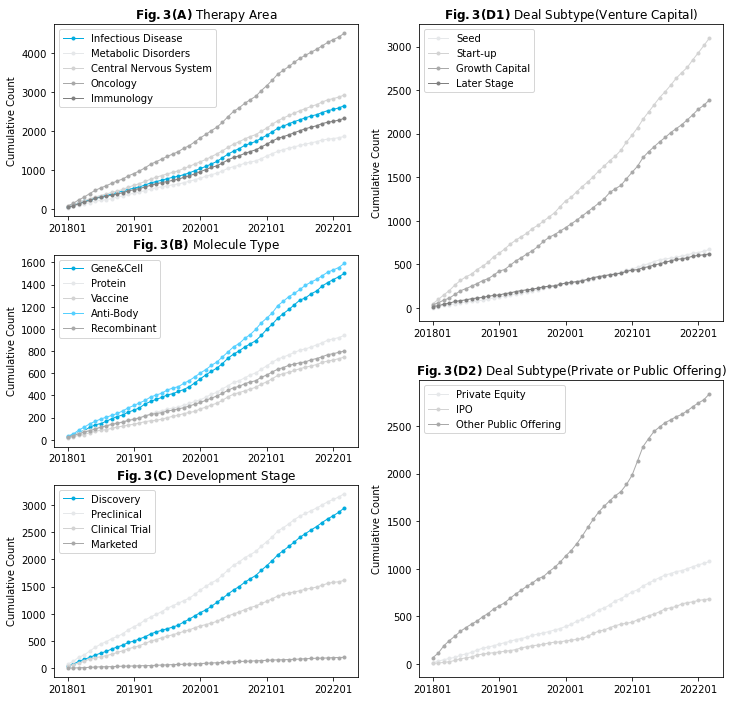

In [282]:
fig = plt.figure()
fig.set_size_inches(12,12)
ax={}

#data = data00.copy()
#data = data.dropna(subset = ['therapy_area','molecule_type','deal_stage'])
#data = data[~(data['l2'].str.startswith('Debt'))&(data['l1'].str.startswith('Capital'))]
data.loc[data.l2 == 'Private Equity', 'l3'] = 'Private Equity'
data['l3_big'] = data['l3']
data.loc[data.l3.str.startswith('PIPE'), 'l3_big'] = 'Other Public Offering'
data.loc[data.l3.str.startswith('Secondary'), 'l3_big'] = 'Other Public Offering'
data['notven'] = [0 if i.startswith("V") else 1 for i in data.l2]

fff = 1
#Therapy
ax[fff] = fig.add_subplot(321)
drug_col = ['drug', 'therapy_area', 'classification',  'deal_stage', 'lead_drug','route', 'stage'] 
deal_big = ['Early Stage VC','Later Stage VC','IPO','Private Equity','Other Public Offering']
deal_big = ['Seed','Start','Growth Capital','Later Stage','IPO','Private Equity','Other Public Offering']
tick = ['201801','201901','202001','202101','202201']
vx = {0:'Venture Capital',
     1: 'Private or Public Offering'}
dx = {0: ["Seed","Start-up","Growth Capital","Later Stage"],
      1: ['Private Equity',"IPO","Other Public Offering"]}
l3x = {0:'l3',1:'l3_big'}
value = 0
cul = 1
filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('ther_Infectious Disease')
filter_col1.insert(0, 'ther_Infectious Disease')
j = 0
line_dic = {}
color = ['#00acdf','#e6e8ea','lightgray','darkgray','gray']
a = 0
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[5:])
    a += 1
ax[fff].set_xticks(tick)
ax[fff].set_title(r"$\bfFig. 3(A)$ Therapy Area")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Cumulative Count")






fff =2
#Mole
value = 0
cul = 1
filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
j = 0
ax[fff] = fig.add_subplot(323)
line_dic = {}
color = ['#00acdf','#e6e8ea','lightgray','#55d0ff','darkgray','gray']
a = 0
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1['value'] = data1['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data2['value'] = data2['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[4:])
    a += 1
ax[fff].set_xticks(tick)
ax[fff].set_title(r"$\bfFig. 3(B)$ Molecule Type")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Cumulative Count")





# Round
value = 0
ax = {}
for j in range(2):
    fff = 222+2*j
    ax[fff] = fig.add_subplot(fff)
    line_dic = {}
    deal = dx[j]
    for k in deal:
        if value == 0:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
        elif value == 1:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
        elif value == 2:
            data1 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
            temp_value = list(data1['value']*data2['headline'].values)
            data2['headline'] = temp_value
        data2 = data2.set_index('ym')
        data2 = data2.sort_index().cumsum()
        line_dic[k], = ax[fff].plot(data2,marker = '.',linewidth=1, markersize=6, color = discovery_color[deal.index(k)+1])
        line_dic[k].set_label(k)
    ax[fff].set_xticks(tick)
    #if j == 0:
     #   ax[fff].set_ylabel("Value")
    ax[fff].legend(loc='upper left')
    ax[fff].set_title(fr"$\bfFig. 3(D{j+1})$ "+f'Deal Subtype({vx[j]})')
    ax[fff].set_ylabel("Cumulative Count")



    
    
    
#Stage
fff =4
ax[fff] = fig.add_subplot(325) #211
lead = 0
deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive', 'Withdrawn', 
         'Filing rejected/Withdrawn', 'Archived', 'Unknown']
if lead == 1:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif 'Discovery' in j:
            temp_deal_stage.append(1)
        else:
            temp_deal_stage.append(0)
else:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if 'Discovery' in j:
            temp_deal_stage.append(1)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        else:
            temp_deal_stage.append(0)
data['temp_deal_stage'] = temp_deal_stage
temp_deal_stage = ['Others','Discovery','Preclinical','Clinical Trial','Marketed']
value = 0
cul = 1
line_dic = {}
market = {0:5,1:4,2:4}
j=0
for k in temp_deal_stage[1:5]:
    if value == 0:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    elif value == 1:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
    elif value == 2:
        data2 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        temp_value = list(data2['value']*data1['headline'].values)
        data1['headline'] = temp_value
    data1 = data1.set_index('ym').sort_index()
    if cul == 1:
        data1 = data1.sort_index().cumsum()
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = discovery_color[temp_deal_stage.index(k)-1])
    print(k,temp_deal_stage.index(k))
    line_dic[k].set_label(k)
ax[fff].set_xticks(tick)    
ax[fff].set_title(r"$\bfFig. 3(C)$ Development Stage")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Cumulative Count")

fig.savefig('manuscript/fig3.jpeg',dpi = 300)


# T test

In [283]:
data['ym_int'] = [int(i) for i in data['ym']]


filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
ther_col = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
ther_col = list(filter(None, ther_col))

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
mol_col = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
mol_col = list(filter(None, mol_col))

data['completed'] = [1 if i == "Completed" else 0 for i in data['status']]
data['entity_desc'] = ""
for i in ["Institution","Private","Public"]:
    data.loc[data.entity_i.str.contains(i), 'entity_desc'] = i
data['regi'] = ""
ap = ["Australia","China","New Zealand","Japan","Singapore","South Korea","India","Hong Kong","Taiwan"]
eu = ["Denmark","Finland","Ireland","Austria","Italy","Belgium","Monaco","Luxembourg","Germany","Norway","Portugal","Bermuda","Spain","Netherlands","Bermuda","Switzerland","Turkey","Sweden","France ","Israel","United Kingdom"]
a = ["Canada" ,"United States"]
for i in ap:
    data.loc[data.hq_i.str.contains(i), 'regi'] = "Asia Pacific"
for i in eu:
    data.loc[data.hq_i.str.contains(i), 'regi'] = "Europe"
for i in a:
    data.loc[data.hq_i.str.contains(i), 'regi'] = "North America"
data.loc[data.regi == "", 'regi'] = "Others"

In [284]:
conti = ['value','num_drug']
for i in conti:
    print(data[i].mean(),data[i].std(),data[data['ym_int']<202103][i].mean(),data[data['ym_int']<202103][i].std(),
          data[data['ym_int']>=202103][i].mean(),data[data['ym_int']>=202103][i].std(),
         stats.ttest_ind(data[data[i]>=0][data['ym_int']<202103][i],data[data[i]>=0][data['ym_int']>=202103][i]))
     
      

68.9580231398683 307.4484752496825 62.808312265026714 230.34590348583868 85.33571421508034 452.366036781828 Ttest_indResult(statistic=-3.555715474963588, pvalue=0.00037842097503243297)
3.7140892973442363 8.008044184515182 3.717948717948718 8.130518579484665 3.703898840885142 7.676310294389181 Ttest_indResult(statistic=0.09205643237856573, pvalue=0.9266545379047981)


In [285]:
#data = data[data['l3']!=""]
#data = data[data['l3']!="0"]
#data = data[data['entity_desc']!=""]
descriptive = ['l3_big','temp_deal_stage']+ther_col+mol_col+['completed','deal_stage_Marketed','entity_desc','regi']
dg_all = pd.DataFrame()
for i in descriptive:
    print(i)
    dg = data.groupby(i)['headline'].count().reset_index()
    dg['Percentage'] = dg['headline']  / dg['headline'].sum()
    dg = dg.set_index(i)
    dg_all = pd.concat([dg_all,dg])


l3_big
temp_deal_stage
ther_Metabolic Disorders
ther_Central Nervous System
ther_Infectious Disease
ther_Oncology
ther_Immunology
mol_Gene&Cell
mol_Protein
mol_Vaccine
mol_Anti-Body
mol_Recombinant
completed
deal_stage_Marketed
entity_desc
regi


In [286]:
dg = pd.DataFrame()
for i in descriptive:
    obs = pd.crosstab(index=data[data['ym_int']>=202003][i], columns="count")
    obs['Percentage'] = obs['count']  / obs['count'].sum()
    exp = pd.crosstab(index=data[data['ym_int']<202003][i], columns="count")
    exp['Percentage'] = exp['count']  / exp['count'].sum()
    obs = exp.merge(obs,how='left',on=i)
    obs['chi'] = stats.chi2_contingency(obs)[0]
    obs['p-val'] = stats.chi2_contingency(obs)[1]
    #obs['sig'] = stats.chi2_contingency(obs)[1]<0.05
    obs['p-val'] = obs['p-val'].round(decimals=3)
    dg = pd.concat([dg,obs])
    

In [287]:

dg_cont = data.groupby(i)['headline'].count().reset_index()
dg = pd.DataFrame()
for i in descriptive:
    obs = pd.crosstab(index=data[data['ym_int']>=202003][i], columns="count")
    obs['Percentage'] = obs['count']  / obs['count'].sum()
    exp = pd.crosstab(index=data[data['ym_int']<202003][i], columns="count")
    exp['Percentage'] = exp['count']  / exp['count'].sum()
    obs = exp.merge(obs,how='left',on=i)
    obs['chi'] = stats.chi2_contingency(obs)[0]
    obs['p-val'] = stats.chi2_contingency(obs)[1]
    #obs['sig'] = stats.chi2_contingency(obs)[1]<0.05
    obs['p-val'] = obs['p-val'].round(decimals=3)
    dg = pd.concat([dg,obs])
    
#dg.to_excel('des.xlsx')

In [288]:
dg

col_0,count_x,Percentage_x,count_y,Percentage_y,chi,p-val
,1212,0.205319,1186,0.149823,94.231291,0.000
0,13,0.002202,27,0.003411,94.231291,0.000
Growth Capital,965,0.163476,1424,0.179889,94.231291,0.000
IPO,251,0.042521,433,0.054699,94.231291,0.000
Later Stage,293,0.049636,328,0.041435,94.231291,0.000
Other Public Offering,1191,0.201762,1647,0.208060,94.231291,0.000
Private Equity,416,0.070473,662,0.083628,94.231291,0.000
Seed,292,0.049466,381,0.048130,94.231291,0.000
Start-up,1270,0.215145,1828,0.230925,94.231291,0.000
0,2422,0.410300,3422,0.432289,108.731661,0.000


In [289]:
dg.to_excel('des.xlsx')

In [290]:
#dg_all.to_excel('desc_.xlsx')

## sup_all

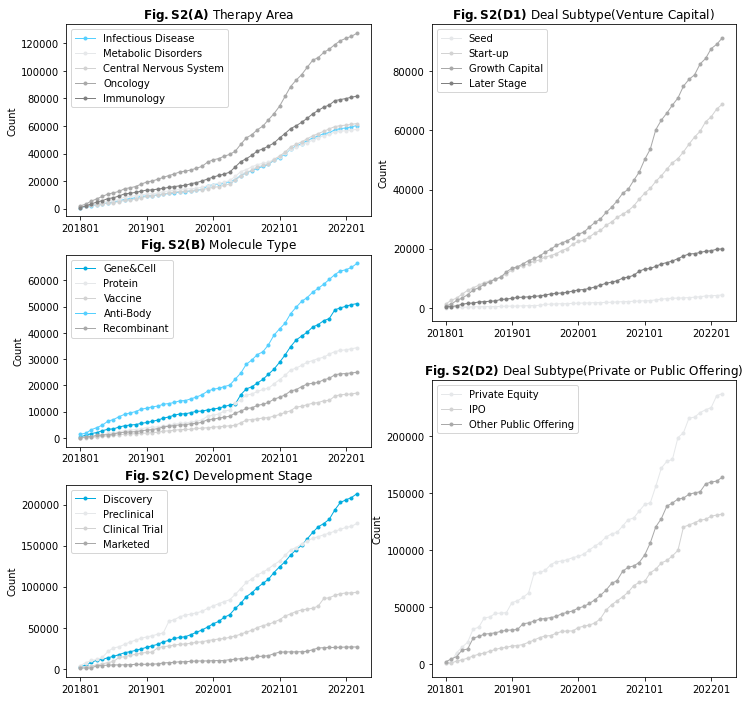

In [291]:
v = 2
fig = plt.figure()
fig.set_size_inches(12,12)
ax={}

data = data00.copy()
data = data.dropna(subset = ['therapy_area','molecule_type','deal_stage'])
data = data[~(data['l2'].str.startswith('Debt'))&(data['l1'].str.startswith('Capital'))]
data.loc[data.l2 == 'Private Equity', 'l3'] = 'Private Equity'
data['l3_big'] = data['l3']
data.loc[data.l3.str.startswith('PIPE'), 'l3_big'] = 'Other Public Offering'
data.loc[data.l3.str.startswith('Secondary'), 'l3_big'] = 'Other Public Offering'
data['notven'] = [0 if i.startswith("V") else 1 for i in data.l2]

fff = 1
#Therapy
ax[fff] = fig.add_subplot(321)
drug_col = ['drug', 'therapy_area', 'classification',  'deal_stage', 'lead_drug','route', 'stage'] 
deal_big = ['Early Stage VC','Later Stage VC','IPO','Private Equity','Other Public Offering']
deal_big = ['Seed','Start','Growth Capital','Later Stage','IPO','Private Equity','Other Public Offering']
tick = ['201801','201901','202001','202101','202201']
vx = {0:'Venture Capital',
     1: 'Private or Public Offering'}
dx = {0: ["Seed","Start-up","Growth Capital","Later Stage"],
      1: ['Private Equity',"IPO","Other Public Offering"]}
l3x = {0:'l3',1:'l3_big'}
value = v
cul = 1
filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
j = 0
line_dic = {}
color = ['#55d0ff','#e6e8ea','lightgray','darkgray','gray']
filter_col1.remove('ther_Infectious Disease')
filter_col1.insert(0, 'ther_Infectious Disease')

a = 0
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[5:])
    a += 1
ax[fff].set_xticks(tick)
ax[fff].set_title(r"$\bfFig. S2(A)$ Therapy Area")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Count")






fff =2
#Mole
value = v
cul = 1
filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
j = 0
ax[fff] = fig.add_subplot(323)
line_dic = {}
color = ['#00acdf','#e6e8ea','lightgray','#55d0ff','darkgray','gray']
a = 0
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1['value'] = data1['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data2['value'] = data2['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[4:])
    a += 1
ax[fff].set_xticks(tick)
ax[fff].set_title(r"$\bfFig. S2(B)$ Molecule Type")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Count")





# Round
value = v
ax = {}
for j in range(2):
    fff = 222+2*j
    ax[fff] = fig.add_subplot(fff)
    line_dic = {}
    deal = dx[j]
    for k in deal:
        if value == 0:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
        elif value == 1:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
        elif value == 2:
            data1 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
            temp_value = list(data1['value']*data2['headline'].values)
            data2['headline'] = temp_value
        data2 = data2.set_index('ym')
        data2 = data2.sort_index().cumsum()
        line_dic[k], = ax[fff].plot(data2,marker = '.',linewidth=1, markersize=6, color = discovery_color[deal.index(k)+1])
        line_dic[k].set_label(k)
    ax[fff].set_xticks(tick)
    #if j == 0:
     #   ax[fff].set_ylabel("Value")
    ax[fff].legend(loc='upper left')
    ax[fff].set_title(fr"$\bfFig. S2(D{j+1})$ "+f'Deal Subtype({vx[j]})')
    ax[fff].set_ylabel("Count")



    
    
    
#Stage
fff =4
ax[fff] = fig.add_subplot(325) #211
lead = 0
deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive', 'Withdrawn', 
         'Filing rejected/Withdrawn', 'Archived', 'Unknown']
if lead == 1:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif 'Discovery' in j:
            temp_deal_stage.append(1)
        else:
            temp_deal_stage.append(0)
else:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if 'Discovery' in j:
            temp_deal_stage.append(1)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        else:
            temp_deal_stage.append(0)
data['temp_deal_stage'] = temp_deal_stage
temp_deal_stage = ['Others','Discovery','Preclinical','Clinical Trial','Marketed']
value = v
cul = 1
line_dic = {}
market = {0:5,1:4,2:4}
j=0
for k in temp_deal_stage[1:5]:
    if value == 0:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    elif value == 1:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
    elif value == 2:
        data2 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        temp_value = list(data2['value']*data1['headline'].values)
        data1['headline'] = temp_value
    data1 = data1.set_index('ym').sort_index()
    if cul == 1:
        data1 = data1.sort_index().cumsum()
    line_dic[k], = ax[fff].plot(data1,marker = '.',linewidth=1, markersize=6, color = discovery_color[temp_deal_stage.index(k)-1])
    line_dic[k].set_label(k)
ax[fff].set_xticks(tick)    
ax[fff].set_title(r"$\bfFig. S2(C)$ Development Stage")
ax[fff].legend(loc='upper left')
ax[fff].set_ylabel("Count")

fig.savefig('manuscript/figS2.jpeg',dpi = 300)


In [292]:
#df_c = pd.concat([df,df2], keys = ["A", "B"])

## acquirer

Venture Financing
Private Equity


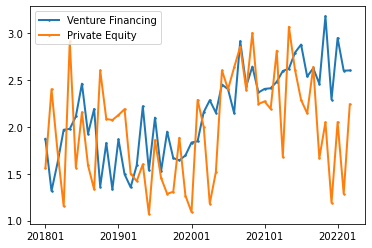

In [293]:
fig,axes = plt.subplots()
for i in ['Venture Financing','Private Equity']:
    line_dic = {}
    print(i)
    data = data00.copy()
    data = data[data['l2']==i]
    dataym1 = data
    dataym1.loc[(dataym1.acquirer != ''),'acquirer'] = dataym1['acquirer']+';'
    dataym1 = pd.DataFrame(dataym1.groupby('ym')['acquirer'].agg('sum'))
    dataym1['acquirer'] = dataym1['acquirer'].str.replace('Undisclosed;','')
    dataym1['acquirer'] = dataym1.acquirer.str.split(';')
    dataym1['acquirer'] = [len(list(set(i))) for i in dataym1['acquirer']]
    dataym2 = pd.DataFrame(data.groupby('ym')['headline'].count())
    dataym3 = data
    dataym3['n_acquirer'] = dataym3.acquirer.str.count(';')+1
    dataym3.loc[(dataym3.acquirer == 'Undisclosed')|(dataym3.acquirer == ''),'n_acquirer'] = 0
    dataym3 = pd.DataFrame(dataym3.groupby('ym')['n_acquirer'].mean())
    dataym0 = dataym1.merge(dataym2,on='ym')
    dataym0 = dataym0.merge(dataym3,on='ym')
    #line_dic[i], = axes.plot(dataym0['n_acquirer'],marker = '.',linewidth=3, markersize=6)
    dataym0['pct'] = dataym0['acquirer']/dataym0['headline']
    line_dic[i], = axes.plot(dataym0['pct'],marker = '.',linewidth=2, markersize=3)
    axes.set_xticks(tick)
    line_dic[i].set_label(i)
    axes.legend(loc='upper left')
    #fig,axes = plt.subplots()
    #line_dic[i], = axes.plot(dataym0['headline'],marker = '.',linewidth=3, markersize=6)
    #line_dic[i], = axes.plot(dataym0['acquirer'],marker = '.',linewidth=3, markersize=6)
    axes.set_xticks(tick)


## round

In [294]:
data = data00.copy()
data = data.dropna(subset = ['therapy_area','molecule_type','deal_stage'])
data = data[~(data['l2'].str.startswith('Debt'))&(data['l1'].str.startswith('Capital'))]
#data = data[(data['l2'].str.startswith('Ve')) | (data['l2'].str.startswith('Pr'))]
data.loc[data.l2 == 'Private Equity', 'l3'] = 'Private Equity'
data['l3_big'] = data['l3']
#data.loc[data.l3.str.startswith('Seed'), 'l3_big'] = 'Early Stage VC'
#data.loc[data.l3.str.startswith('Start'), 'l3_big'] = 'Early Stage VC'
#data.loc[data.l3.str.startswith('Growth'), 'l3_big'] = 'Later Stage VC'
data.loc[data.l3.str.startswith('PIPE'), 'l3_big'] = 'Other Public Offering'
data.loc[data.l3.str.startswith('Secondary'), 'l3_big'] = 'Other Public Offering'
#data.loc[data.l2.str.startswith('Debt'), 'l3_big'] = 'Debt Offering'
data['notven'] = [0 if i.startswith("V") else 1 for i in data.l2]


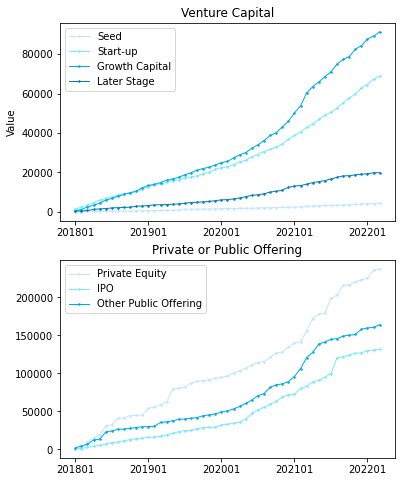

In [295]:
value = 2

fig = plt.figure(figsize=(6,8))
ax = {}

for j in range(2):
    ax[j] = fig.add_subplot(211+j)
    line_dic = {}
    deal = dx[j]
    for k in deal:
        if value == 0:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
        elif value == 1:
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
        elif value == 2:
            data1 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'value']].groupby('ym').mean().reset_index()
            data2 = data[data['notven']==j][data[l3x[j]]==k][['ym', 'headline']].groupby('ym').count().reset_index()
            temp_value = list(data1['value']*data2['headline'].values)
            data2['headline'] = temp_value
        data2 = data2.set_index('ym')
        data2 = data2.sort_index().cumsum()
        line_dic[k], = ax[j].plot(data2,marker = '.',linewidth=1, markersize=3, color = blue_color[deal.index(k)])
        line_dic[k].set_label(k)
    ax[j].set_title(vx[j])
    ax[j].set_xticks(tick)
    if j == 0:
        ax[j].set_ylabel("Value")
    ax[j].legend(loc='upper left')#




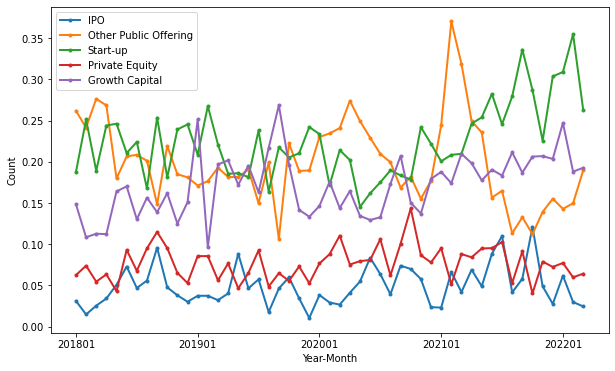

In [296]:
fig,axes = plt.subplots()
line_dic = {}
deal = list(set(data['l3_big'].values))
deal.remove('')
deal.remove('0')
a =  [len(data[data['l3_big']==i]) for i in deal]
a.sort()
a = a[-5]
filter_col1 = [i if len(data[data['l3_big']==i])>=a else '' for i in deal] 
filter_col1 = list(filter(None, filter_col1))
data1_ = data[['ym', 'headline']].groupby('ym').count().reset_index()
data1_ = data1_.merge(dataym, how='right', on='ym')
data1_['headline'] = data1_['headline'].apply(lambda d: 0 if np.isnan(d) else d)
for k in filter_col1:
    data1 = data[(data['l3_big']==k)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1['headline'] = data1['headline']/(data1_['headline']+1)
    data1 = data1.set_index('ym')  
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=2, markersize=6)
    line_dic[k].set_label(k)
plt.xticks(['201801','201901','202001','202101','202201'])
axes.set_xlabel("Year-Month")
axes.set_ylabel("Count")
axes.legend(loc='upper left')#
fig.set_size_inches(10,6)
#fig.savefig('manuscript/fig2a.jpeg',dpi = 300)


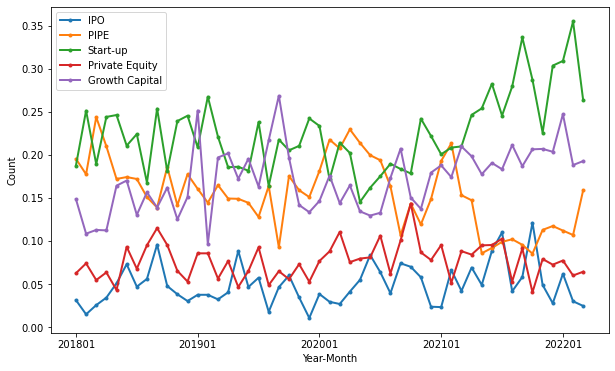

In [297]:
fig,axes = plt.subplots()
line_dic = {}
deal = list(set(data['l3'].values))
deal.remove('')
deal.remove('0')
a =  [len(data[data['l3']==i]) for i in deal]
a.sort()
a = a[-5]
filter_col1 = [i if len(data[data['l3']==i])>=a else '' for i in deal] 
filter_col1 = list(filter(None, filter_col1))
data1_ = data[['ym', 'headline']].groupby('ym').count().reset_index()
data1_ = data1_.merge(dataym, how='right', on='ym')
data1_['headline'] = data1_['headline'].apply(lambda d: 0 if np.isnan(d) else d)
for k in filter_col1:
    data1 = data[(data['l3']==k)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1['headline'] = data1['headline']/(data1_['headline']+1)
    data1 = data1.set_index('ym')  
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=2, markersize=6)
    line_dic[k].set_label(k)
plt.xticks(['201801','201901','202001','202101','202201'])
axes.set_xlabel("Year-Month")
axes.set_ylabel("Count")
axes.legend(loc='upper left')#
fig.set_size_inches(10,6)
#fig.savefig('manuscript/fig2a.jpeg',dpi = 300)


## stage

In [298]:
lead = 0
deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive', 'Withdrawn', 
         'Filing rejected/Withdrawn', 'Archived', 'Unknown']
if lead == 1:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif 'Discovery' in j:
            temp_deal_stage.append(1)
        else:
            temp_deal_stage.append(0)
else:
    temp_deal_stage = []
    for j in data['deal_stage']:
        if 'Discovery' in j:
            temp_deal_stage.append(1)
        elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
            temp_deal_stage.append(2)
        elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
            temp_deal_stage.append(3)
        elif ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
            temp_deal_stage.append(4)
        else:
            temp_deal_stage.append(0)
data['temp_deal_stage'] = temp_deal_stage
temp_deal_stage = ['Others','Discovery','Preclinical','Clinical Trial','Marketed']


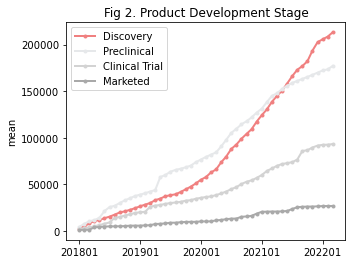

In [299]:
value = 2
cul = 1
line_dic = {}
ax = {}
market = {0:5,1:4,2:4}
fig = plt.figure(figsize=(5,4))
j=0
ax[j] = fig.add_subplot(111+j) #211
color = ['lightcoral','#e6e8ea','lightgray','darkgray','gray']

for k in temp_deal_stage[1:5]:
    if value == 0:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    elif value == 1:
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
    elif value == 2:
        data2 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
        data1 = data[((data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        temp_value = list(data2['value']*data1['headline'].values)
        data1['headline'] = temp_value
    data1 = data1.set_index('ym').sort_index()
    if cul == 1:
        data1 = data1.sort_index().cumsum()
    line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=2, markersize=6, color = color[temp_deal_stage.index(k)-1])
    line_dic[k].set_label(k)
ax[j].set_ylabel("mean")
ax[j].legend(loc='upper left')
ax[j].set_xticks(tick)    
ax[j].set_title('Fig 2. Product Development Stage')
ax[j].legend(loc=0)
#fig.set_size_inches(8,6)
width = 0.35 


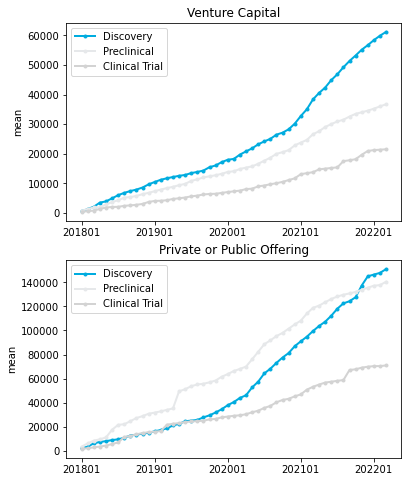

In [300]:
value = 2
cul = 1
line_dic = {}
ax = {}
market = {0:5,1:4,2:4}
fig = plt.figure(figsize=(6,8))
for j in range(2):
    ax[j] = fig.add_subplot(211+j)
    for k in temp_deal_stage[1:market[value]]:
        if value == 0:
            data1 = data[((data['notven'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        elif value == 1:
            data1 = data[((data['notven'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
        elif value == 2:
            data2 = data[((data['notven'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
            data2['value'] = data2['value'].apply(lambda d: 0 if np.isnan(d) else d)
            data2 = data2.merge(dataym, how='right', on='ym')
            data1 = data[((data['notven'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            data1['headline'] = data2['value']*data1['headline']
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1.sort_index().cumsum()
        line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=2, markersize=6, color = discovery_color[temp_deal_stage.index(k)-1])
        line_dic[k].set_label(k)
    ax[j].set_ylabel("mean")
    ax[j].legend(loc='upper left')
    ax[j].set_xticks(tick)    
    ax[j].set_title(vx[j])
    ax[j].legend(loc=0)
    #fig.set_size_inches(8,6)
    width = 0.35 


## another all

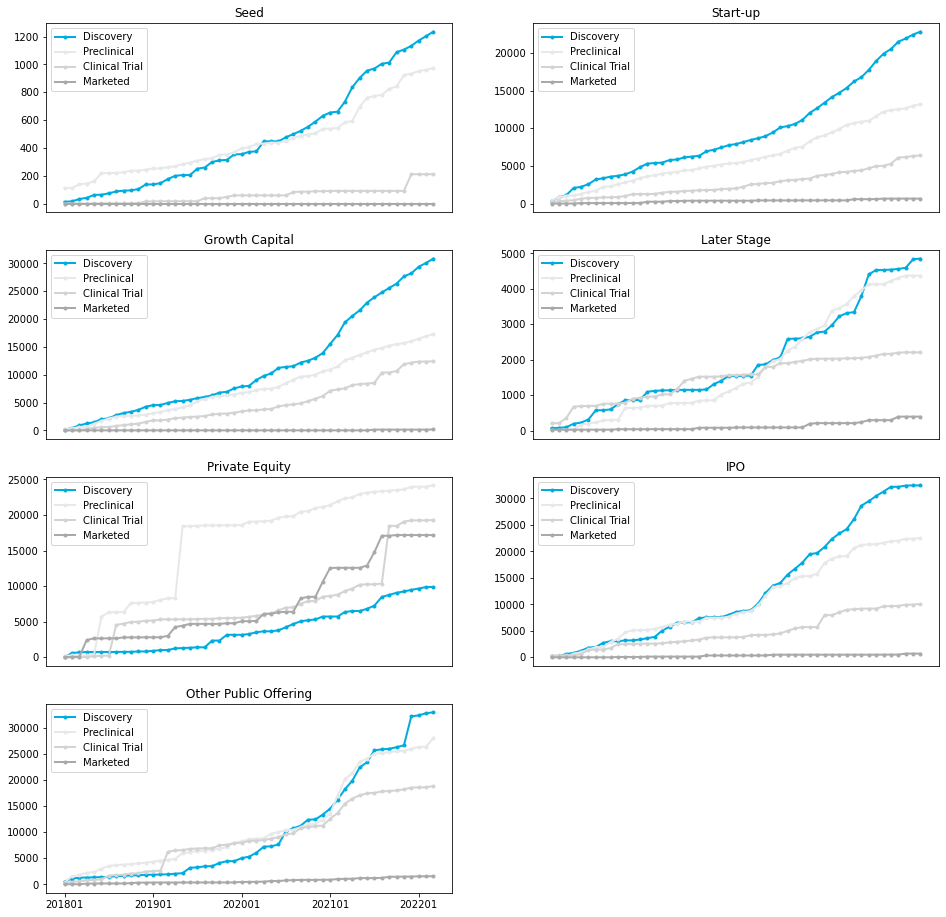

In [301]:
deal = dx[0]+dx[1]
value = 2
cul = 1
line_dic = {}
ax = {}
market = {0:5,1:4,2:5}
fig = plt.figure(figsize=(16,16))
for j in deal:
    ax[j] = fig.add_subplot(421+deal.index(j))
    for k in temp_deal_stage[1:market[value]]:
        if value == 0:
            data1 = data[((data['l3_big'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        elif value == 1:
            data1 = data[((data['l3_big'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
        elif value == 2:
            data2 = data[((data['l3_big'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'value']].groupby('ym').mean().reset_index()#better vc only
            data2 = data2.merge(dataym, how='right', on='ym')
            data2['value'] = data2['value'].apply(lambda d: 0 if np.isnan(d) else d)
            data1 = data[((data['l3_big'] == j)&(data['temp_deal_stage']==temp_deal_stage.index(k)))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            temp_value = list(data2['value']*data1['headline'].values)
            data1['headline'] = temp_value
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1.sort_index().cumsum()
        line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=2, markersize=6, color = discovery_color[temp_deal_stage.index(k)-1])
        line_dic[k].set_label(k)
    #ax[j].set_ylabel("Cumulative Amount (In million USD)")
    ax[j].legend(loc='upper left')
    ax[j].set_xticks([])  
    ax[j].set_title(j)
    ax[j].legend(loc=0)
    width = 0.35 
ax[j].set_xticks(tick)  
fig.savefig('manuscript/figs3.jpeg',dpi = 300)



#old
pct = 0
cul = 1
line_dic = {}
#fig, ax1 = plt.subplots()
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax4 = fig.add_subplot(414)

if pct == 1:
    data1_ = data[(data['temp_deal_stage'] == 1) | (data['temp_deal_stage'] == 2) | (data['temp_deal_stage'] == 3) |(data['temp_deal_stage'] == 4)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1_ = data1_.merge(dataym, how='right', on='ym')
    data1_['headline'] = data1_['headline'].apply(lambda d: 0 if np.isnan(d) else d)
for k in temp_deal_stage[1:]:
    data1 = data[((data['l2'].str.startswith("V")))&(data['temp_deal_stage']==temp_deal_stage.index(k))][['ym', 'headline']].groupby('ym').count().reset_index()#better vc only
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    if pct == 1:
        data1['headline'] = data1['headline']/(data1_['headline']+1)
    data1 = data1.set_index('ym').sort_index()
    if cul == 1:
        data1 = data1.sort_index().cumsum()
    line_dic[k], = ax1.plot(data1,marker = '.',linewidth=2, markersize=6, color = blue_color[temp_deal_stage.index(k)-1])
    line_dic[k].set_label(k)
ax1.set_ylabel("Count")
ax1.legend(loc='upper left')#axes.legend()
ax1.set_xticks(['201801','201901','202001','202101','202201'])    
ax1.set_title('Venture Capital')
ax1.legend(loc=0)
#fig.set_size_inches(8,6)
width = 0.35 



deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive', 'Withdrawn', 
         'Filing rejected/Withdrawn', 'Archived', 'Unknown']
temp_deal_stage = []
for j in data['deal_stage']:
    if 'Discovery' in j:
        temp_deal_stage.append(1)
    elif ('Preclinical' in j)  or ('IND/CTA Filed' in j) or ('Phase 0' in j):
        temp_deal_stage.append(2)
    elif ('Phase I' in j) or ('Phase II' in j) or ('Phase III' in j) :
        temp_deal_stage.append(3)
    elif ('Marketed' in j) or ('Archived (Marketed)' in j)or ('Pre-Registration' in j):
        temp_deal_stage.append(4)
    else:
        temp_deal_stage.append(0)
data['temp_deal_stage'] = temp_deal_stage
#temp_deal_stage = ['Others','Discovery','Preclinical','Clinical Trial','Marketed']
temp_deal_stage = ['Discovery','Preclinical','Clinical Trial','Marketed']


line_dic = {}
fig, ax1 = plt.subplots()
for k in temp_deal_stage:
    data1 = data[(data['temp_deal_stage']==temp_deal_stage.index(k)+1)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym').sort_index()
    line_dic[k], = ax1.plot(data1,marker = 'o',linewidth=2, markersize=6, color = blue_color[temp_deal_stage.index(k)])
    line_dic[k].set_label(k)
axes.set_xlabel("ym")
axes.set_ylabel("Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
plt.xticks(['201801','201901','202001','202101','202201'])    

ax1.legend(loc=0)
fig.set_size_inches(12,8)
width = 0.35 


### Old Stage

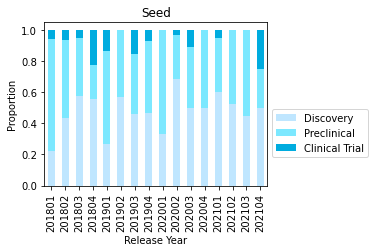

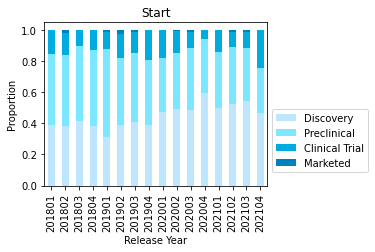

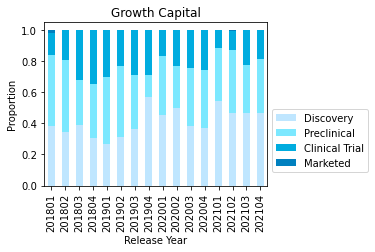

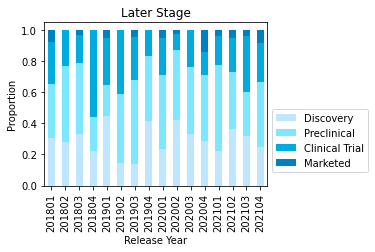

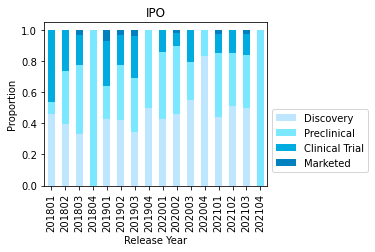

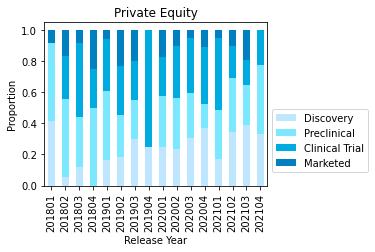

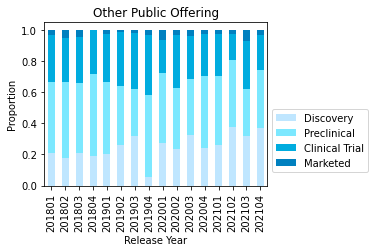

In [302]:
temp_deal_stage = ['Discovery','Preclinical','Clinical Trial','Marketed']
deal_stage_dic = {}
for i in range(len(temp_deal_stage)):
    deal_stage_dic[i+1] = temp_deal_stage[i]
    
data1 = data[data['temp_deal_stage']!=0][data['l3']!=""][data['yr']!="2022"]
for i in deal_big:
#for i in ["Seed",'Start','Later','Growth']:
    cross_tab_prop = pd.crosstab(columns=data1[data1['l3_big'].str.startswith(i)]['temp_deal_stage'],
                                 index=data1[data1['l3_big'].str.startswith(i)]['yq'],normalize="index")#
    cross_tab_prop = cross_tab_prop.rename(columns=deal_stage_dic)
    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        color=blue_color, 
                        figsize=(4,3))

    plt.legend(loc="upper left", ncol=2)
    plt.xlabel("Release Year")
    plt.ylabel("Proportion")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
    plt.title(i)
    plt.show()

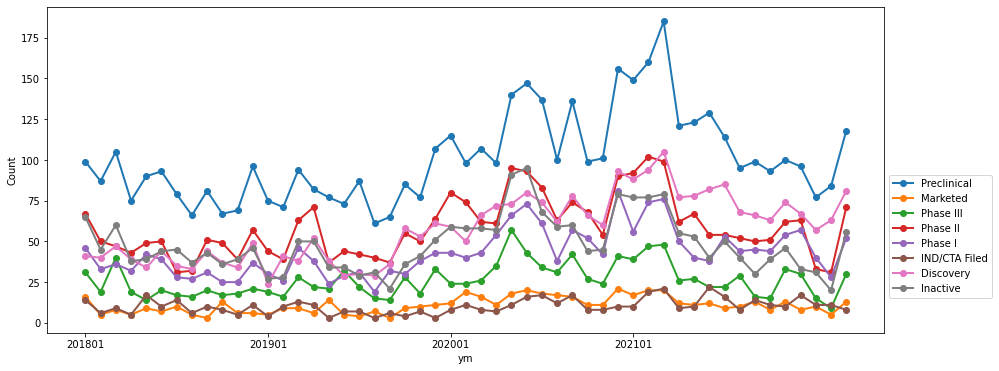

In [303]:
deal_stage = ['Archived (Marketed)', 'Marketed','Pre-Registration', 'Phase III', 'Phase II', 'Phase I', 
         'Phase 0','IND/CTA Filed','Preclinical', 'Discovery','Discontinued', 'Inactive',  'Archived', 
         'Unknown','Withdrawn', 'Filing rejected/Withdrawn']
for i in deal_stage:
    data[f'deal_stage_{i}'] = data['deal_stage'].apply(lambda x: 1 if (i in x) else 0)
filter_mol = [mol for mol in data if mol.startswith('deal_stage_')]
th = np.quantile([data[f'{col}'].sum() for col in filter_mol],0.5)
filter_mol1 = [i if (data[i].sum()>=th) else '' for i in filter_mol] 
filter_mol1 = list(filter(None, filter_mol1))
filter_mol1.remove('deal_stage_Preclinical')
filter_mol1.insert(0, 'deal_stage_Preclinical')

fig,axes = plt.subplots()#[data['lead_drug']==["Yes"]]
for k in filter_mol1:
    line_dic[k], = axes.plot(data[(data[k]==1)][['ym', 'headline']].groupby('ym').count(),
                             marker = 'o',linewidth=2, markersize=6)
    line_dic[k].set_label(k[11:])
    plt.xticks(['201801','201901','202001','202101'])
axes.set_xlabel("ym")
axes.set_ylabel("Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
fig.set_size_inches(15,6)


## therapy area

Text(0.5, 1.0, 'Fig 1. Disease Area')

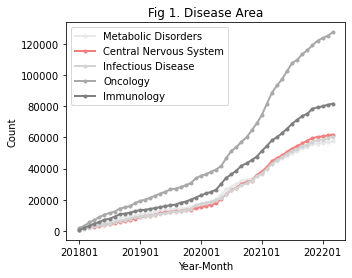

In [304]:
value = 2
cul = 1

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))

fig = plt.figure(figsize=(5,4))
ax = {}
j = 0
ax[j] = fig.add_subplot(111+j)
line_dic = {}
a = 0
color = ['#e6e8ea','lightcoral','lightgray','darkgray','gray']
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=2, markersize=6,  color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[5:])
    a += 1
ax[j].set_xticks(tick)
ax[j].set_xlabel("Year-Month")
ax[j].set_ylabel("Count")
ax[j].legend(loc='upper left')
ax[j].set_title('Fig 1. Disease Area')

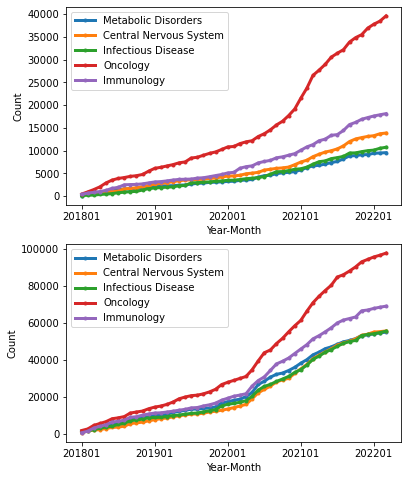

In [305]:
value = 2
cul = 1

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))

fig = plt.figure(figsize=(6,8))
ax = {}

for j in range(2):
    ax[j] = fig.add_subplot(211+j)
    line_dic = {}
    a = 0
    for k in filter_col1:
        if value == 0:
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            data1 = data1.set_index('ym').sort_index()
            if cul == 1:
                data1 = data1['headline'].cumsum()
        elif value == 1:
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
            data1 = data1.set_index('ym').sort_index()
            if cul == 1:
                data1 = data1['value'].cumsum() 
        elif value == 2:
            data2 = data[data['notven']==j][(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            data1['headline'] = data2['value']*data1['headline']
            data1 = data1.set_index('ym').sort_index()            
            if cul == 1:
                data1 = data1['headline'].cumsum() 
        line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=3, markersize=6)
        line_dic[k].set_label(k[5:])
        a += 1
    ax[j].set_xticks(tick)
    ax[j].set_xlabel("Year-Month")
    ax[j].set_ylabel("Count")
    ax[j].legend(loc='upper left')

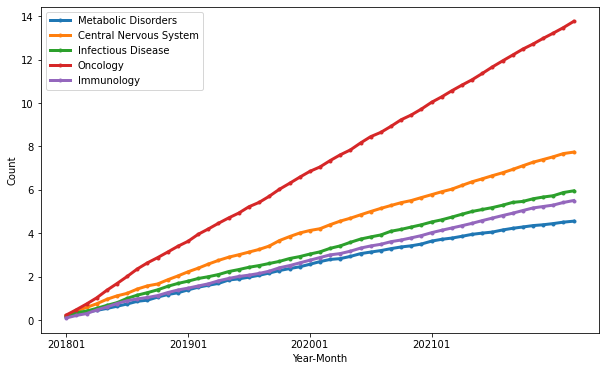

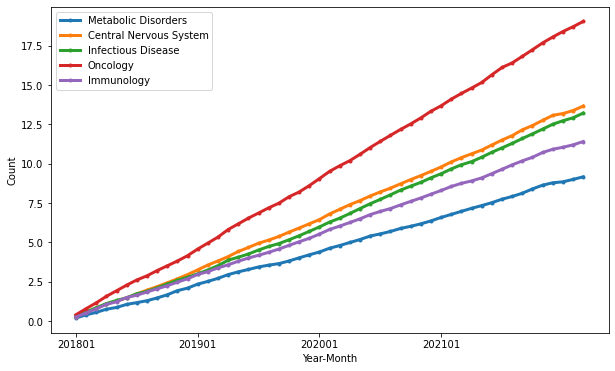

In [306]:
cul = 1

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))

for j in range(2):
    fig,axes = plt.subplots()
    line_dic = {}
    a = 0
    data1_ = data[data['notven']==j][['ym', 'headline']].groupby('ym').count().reset_index()
    data1_ = data1_.merge(dataym, how='right', on='ym')
    for k in filter_col1:
        data1 = data[data['notven']==j][(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data1['headline']/(data1_['headline']+1)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
        line_dic[k], = axes.plot(data1,marker = '.',linewidth=3, markersize=6)#color = color_list[a],
        line_dic[k].set_label(k[5:])
        a += 1
    plt.xticks(['201801','201901','202001','202101'])
    axes.set_xlabel("Year-Month")
    axes.set_ylabel("Count")
    axes.legend(loc='upper left')#, bbox_to_anchor=(1, 0.5)
    fig.set_size_inches(10,6)



Seed
Start-up
Growth Capital
Later Stage
Private Equity
IPO
Other Public Offering


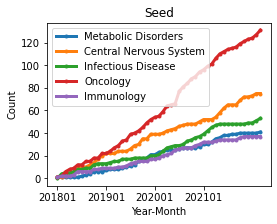

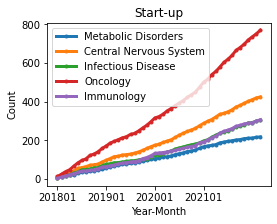

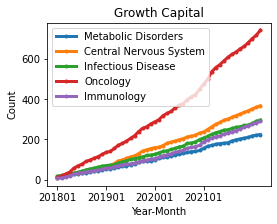

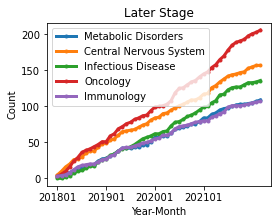

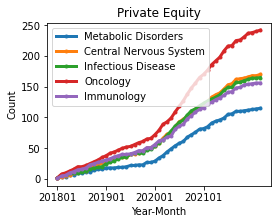

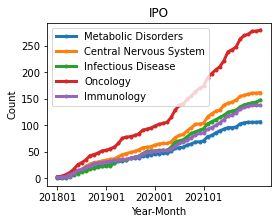

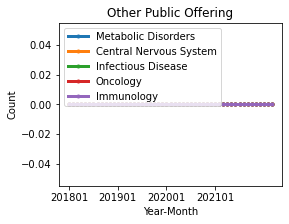

In [307]:
#color_list = ['goldenrod','darkseagreen','gold','limegreen','forestgreen']
for i in deal:
    print(i)
    fig,axes = plt.subplots()
    line_dic = {}
    a = 0
    for k in filter_col1:
        data1 = data[(data[k]==1)&(data['l3']==i)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
        line_dic[k], = axes.plot(data1,marker = '.',linewidth=3, markersize=6)#color = color_list[a],
        line_dic[k].set_label(k[5:])
        a += 1

    plt.xticks(['201801','201901','202001','202101'])
    plt.title(f'{i}')
    axes.set_xlabel("Year-Month")
    axes.set_ylabel("Count")
    axes.legend(loc='upper left')#, bbox_to_anchor=(1, 0.5)
    fig.set_size_inches(4,3)

#fig.savefig('manuscript/fig3a.jpeg',dpi = 300)



## mole type

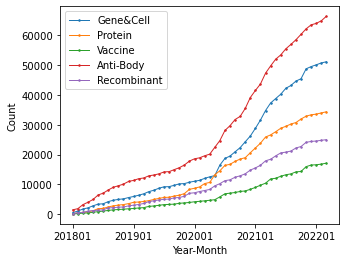

In [308]:
value = 2
cul = 1

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))

fig = plt.figure(figsize=(5,4))
ax = {}
j = 0
ax[j] = fig.add_subplot(111+j)
line_dic = {}
a = 0
for k in filter_col1:
    if value == 0:
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['headline'].cumsum()
    elif value == 1:
        data1 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data1['value'] = data1['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data1.set_index('ym').sort_index()
        if cul == 1:
            data1 = data1['value'].cumsum() 
    elif value == 2:
        data2 = data[(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
        data2['value'] = data2['value'].apply(lambda d: 0 if np.isnan(d) else d)
        data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
        data1 = data1.merge(dataym, how='right', on='ym')
        data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
        data1['headline'] = data2['value']*data1['headline']
        data1 = data1.set_index('ym').sort_index()            
        if cul == 1:
            data1 = data1['headline'].cumsum() 
    line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=1, markersize=3)
    line_dic[k].set_label(k[4:])
    a += 1
ax[j].set_xticks(tick)
ax[j].set_xlabel("Year-Month")
ax[j].set_ylabel("Count")
ax[j].legend(loc='upper left')

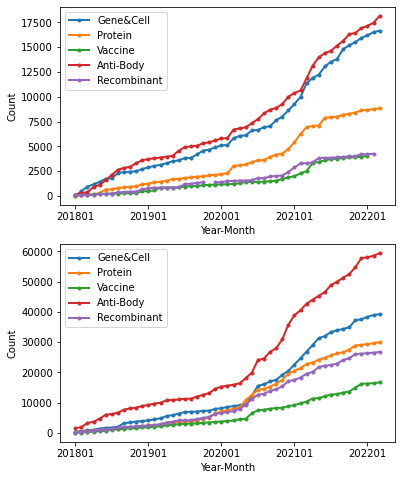

In [309]:
value = 2
cul = 1

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]

filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
#filter_col1 = ['mol_Gene&Cell','mol_Anti-Body','mol_Vaccine','mol_Oligonucleotide']#,'mol_RNA'


fig = plt.figure(figsize=(6,8))
ax = {}

for j in range(2):
    ax[j] = fig.add_subplot(211+j)
    line_dic = {}
    a = 0
    for k in filter_col1:
        if value == 0:
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            data1 = data1.set_index('ym').sort_index()
            if cul == 1:
                data1 = data1['headline'].cumsum()
        elif value == 1:
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
            data1 = data1.set_index('ym').sort_index()
            if cul == 1:
                data1 = data1['value'].cumsum() 
        elif value == 2:
            data2 = data[data['notven']==j][(data[k]==1)][['ym', 'value']].groupby('ym').median().reset_index()
            data1 = data[data['notven']==j][(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
            data1 = data1.merge(dataym, how='right', on='ym')
            data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
            data1['headline'] = data2['value']*data1['headline']
            data1 = data1.set_index('ym').sort_index()            
            if cul == 1:
                data1 = data1['headline'].cumsum() 
        line_dic[k], = ax[j].plot(data1,marker = '.',linewidth=2, markersize=6)
        line_dic[k].set_label(k[4:])
        a += 1
    ax[j].set_xticks(tick)
    ax[j].set_xlabel("Year-Month")
    ax[j].set_ylabel("Count")
    ax[j].legend(loc='upper left')
    
    

mol_Gene&Cell
mol_Anti-Body
mol_Vaccine
mol_Oligonucleotide


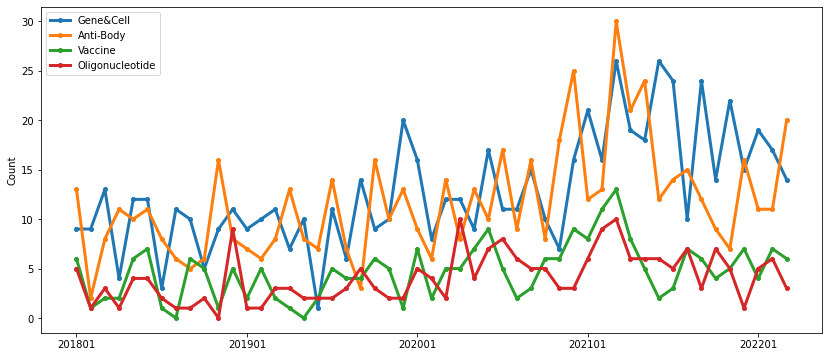

In [310]:
filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-6:]

filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1 = ['mol_Gene&Cell','mol_Anti-Body','mol_Vaccine','mol_Oligonucleotide']#,'mol_RNA'

line_dic = {}
#color_list = ['gold','goldenrod','limegreen','forestgreen','yellowgreen']
mark_list = ['o','o','o','x','x','x']
fig,axes = plt.subplots()
for k in filter_col1:
    fig.set_size_inches(14,6)
    print(k)
    data1 = data[(data['l2'].str.startswith('V'))&(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=3, markersize=8)#color = color_list[filter_col1.index(k)],
    plt.xticks(['201801','201901','202001','202101','202201'])
    line_dic[k].set_label(k[4:])
    axes.set_ylabel("Count")# Private
axes.legend(loc='upper left')#axes.legend()


In [311]:
#data.to_excel("vc_new_2.xlsx",engine='xlsxwriter')

## Value

In [312]:
ym_lst = list(set(data['ym']))
ym_lst.sort()
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
vc = data[['ym','value']].groupby('ym').mean().reset_index()
vc['count'] = data[['ym','headline']].groupby('ym').count().reset_index()['headline']
vc['n'] = data[['ym','value']].groupby('ym').count().reset_index()['value']
vc['std'] = [np.std(data['value'][data['ym'] == i]) for i in ym_lst]
vc['ci'] = 1.96 * np.std(vc['std'])/np.sqrt(vc['n']) 
fig.add_trace(go.Bar(name='Value',
                     x=vc.ym.values, y=vc.value.values))#error_y=dict(type='data', array=vc.ci.values)
fig.add_trace(go.Scatter(name='Count',x=vc.ym.values, y=vc['count'].values),secondary_y=True)
fig.update_yaxes(title_text="Value (USD million)", secondary_y=False)
fig.update_yaxes(title_text="Count", secondary_y=True)
fig.update_layout(barmode='group')

fig.show()


## Num Drug

##l3 = Growth Capital
fig,axes = plt.subplots()
line, = axes.plot(data[data['l3'].str.startswith('Gr')][(data['l2']==l2_input)][['ym', 'num_drug']].groupby('ym').mean().sort_index(),
                  marker = 'o',linewidth=2, markersize=6)
line.set_label('Number of Drugs')
#plt.xticks(['201801','201901','202001','202101'])
axes.set_xlabel("YM")
axes.set_ylabel("Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
fig.set_size_inches(15,6)

##l3 = Startup
fig,axes = plt.subplots()
line, = axes.plot(data[data['l3'].str.startswith('Start')][(data['l2']==l2_input)][['ym', 'num_drug']].groupby('ym').mean().sort_index(),
                  marker = 'o',linewidth=2, markersize=6)
line.set_label('Number of Drugs')
#plt.xticks(['201801','201901','202001','202101'])
axes.set_xlabel("YM")
axes.set_ylabel("Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
fig.set_size_inches(15,6)



## Route

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-4:]

filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
#filter_col1 = ['mol_Gene&Cell','mol_Anti-Body','mol_Vaccine','mol_RNA']#,'mol_Oligonucleotide'
line_dic = {}

#color_list = ['gold','goldenrod','limegreen','forestgreen','yellowgreen']
mark_list = ['o','o','o','x','x','x']
fig,axes = plt.subplots()
for k in filter_col1:
    fig.set_size_inches(14,6)
    print(k)
    data1 = data[(data['ther_Oncology']!=2)&(data[k]==1)][['ym', 'headline']].groupby('ym').count().reset_index()
    data1 = data1.merge(dataym, how='right', on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=3, markersize=8)#color = color_list[filter_col1.index(k)],
    plt.xticks(['201801','201901','202001','202101','202201'])
    line_dic[k].set_label(k[4:])
    axes.set_ylabel("Count")# Private
filter_mol = [mol for mol in data if mol.startswith('route_')]
th = np.quantile([data[f'{col}'].sum() for col in filter_mol],0.6)
filter_mol1 = [i if (data[i].sum()>=th) else '' for i in filter_mol] 
filter_mol1 = list(filter(None, filter_mol1))


line_dic = {}



fig,axes = plt.subplots()
for k in filter_mol1:
    line_dic[k], = axes.plot(data[(data['l2']==l2_input) &(data[k]==1)][['yq', 'headline']].groupby('yq').count().sort_index(),
                             marker = 'o',linewidth=2, markersize=6)
    line_dic[k].set_label(k[6:])
plt.xticks(['201801','201901','202001','202101'])
axes.set_xlabel("YQ")
axes.set_ylabel("Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))#axes.legend()
fig.set_size_inches(15,6)


#fig.savefig('test2png.png', dpi=100)


# Partnership

In [313]:
data['mol_Small'].sum()

KeyError: 'mol_Small'

In [ ]:
data = data00.copy()
data = data.dropna(subset = ['therapy_area','molecule_type','deal_stage'])
data = data[data['l1'].str.startswith('St')]


## subtype

In [ ]:
cul = 1
color = ['lightcoral','#e6e8ea','lightgray','darkgray','gray']
#color = ['lightcoral','gray','darkgray','lightgray','coldgray','whitesmoke']

s_l2_lst = ['Partnership','Licensing Agreement']

fig,axes = plt.subplots()
line_dic = {}
for k in s_l2_lst:
    data1 = data[data['ther_Infectious Disease']==1][(data['l2'].str.startswith(k))][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = axes.plot(data1,marker = '.')#,color = color[s_l2_lst.index(k)]
    line_dic[k].set_label(k)


plt.xticks(tick)
axes.set_title("Fig. 2(c)")
axes.set_title("Partnership")
axes.set_xlabel("YM")
axes.set_ylabel("Count")
axes.legend(loc='upper left')
fig.set_size_inches(5,4)

## therapy area

In [ ]:
data1 = data[(data['ther_Infectious Disease']==1)][['yr', 'headline']].groupby('yr').count()

In [ ]:
data1

In [ ]:
cul = 1
color = ['lightcoral','#e6e8ea','lightgray','darkgray','gray']
#color = ['lightcoral','gray','darkgray','lightgray','coldgray','whitesmoke']

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[:-6]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('ther_Infectious Disease')
filter_col1.insert(0,'ther_Infectious Disease')

fig,axes = plt.subplots()
line_dic = {}
for k in filter_col1:
    data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = axes.plot(data1,marker = '.')#,color = color[filter_col1.index(k)]
    line_dic[k].set_label(k[5:])


plt.xticks(tick)

axes.set_title("Partnership")
axes.set_xlabel("YM")
axes.set_ylabel("Count")
#axes.legend()
axes.set_title("Fig. 2(a)")

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(5,4)


In [ ]:
cul = 1
infe = 0
color = ['lightcoral','#e6e8ea','lightgray','darkgray','gray']


filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('mol_Vaccine')
filter_col1.insert(0,'mol_Vaccine')

fig,axes = plt.subplots()
line_dic = {}
for k in filter_col1:
    data1 = data[data['ther_Infectious Disease']!=infe][(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1 = data1.set_index('ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=1,markersize=3)#,color = color[filter_col1.index(k)]
    line_dic[k].set_label(k[4:])


plt.xticks(tick)
axes.set_title("Fig. 2(b)")
axes.set_xlabel("YM")
axes.set_ylabel("Count")
#axes.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(5,4)

In [ ]:
cul = 1
infe = 0
color = ['lightcoral','#e6e8ea','lightgray','darkgray','gray']


filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('mol_Vaccine')
filter_col1.insert(0,'mol_Vaccine')

fig,axes = plt.subplots()
line_dic = {}
for k in filter_col1:
    data1 = data[data['ther_Infectious Disease']!=infe][(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1 = data1.set_index('ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = axes.plot(data1,marker = '.',linewidth=1,markersize=3)#,color = color[filter_col1.index(k)]
    line_dic[k].set_label(k[4:])


plt.xticks(tick)
axes.set_title("Fig. 2(b)")
axes.set_xlabel("YM")
axes.set_ylabel("Count")
#axes.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(5,4)

In [ ]:
dataout = data[data['l2'].str.startswith("Li")][data['ym'].str.startswith('202107')][data['mol_Vaccine']==1]
#dataout.to_excel('partnership analysis.xlsx')

## public-private

In [ ]:
cul = 1
infe = 0
a = []
filter_col = list(data['entity_ai'].values)
filter_col = list(set(filter_col))
for i in filter_col:
    a.append(len(data[data['entity_ai']==i]))
a.sort()
a = a[-5:]
filter_col1 = [i if len(data[data['entity_ai']==i])>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))

temp_pp = []

for j in data['entity_ai']:
    if ('Institution' in j) or ('Government' in j):
        temp_pp.append('Institution + Public/Private')
    elif  ("Public" in j) &  ("Private" in j):
        temp_pp.append('Public + Private')
    elif ('Public' in j)  :
        temp_pp.append('Public')
    elif ('Private' in j):
        temp_pp.append('Private')
    else:
        temp_pp.append('')

data['temp_pp'] = temp_pp
data.loc[data.acquirer.str.contains("University"), 'temp_pp'] = 'Institution + Public/Private'
#temp_pp.append('University')
temp_pp = list(set(temp_pp))
temp_pp.remove('Institution + Public/Private')
temp_pp.insert(1,'Institution + Public/Private')


color = ['lightcoral','#e6e8ea','darkgray','gray','lightgray']
fig,axes = plt.subplots()
line_dic = {}
data1_ = data[['ym', 'headline']].groupby('ym').count()
for k in temp_pp[1:]:
    #line_dic[k], = axes.fill(data[(data['l2']==l2_input) &(data['temp_pp']==k)][['ym', 'headline']].groupby('ym').count())
    data1 = data[data['ther_Infectious Disease'] != infe][(data['temp_pp']==k)][['ym', 'headline']].groupby('ym').count()
    #data1['headline'] = data1.pct_change(12)
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    #data1['headline'] = data1['headline'].apply(lambda d: 1 if np.isinf(d) else d)
    #data1['headline'] = data1['headline']/(data1_['headline'])
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = axes.plot(data1,marker = '.', linewidth=2,color = color[temp_pp.index(k)-1])
    line_dic[k].set_label(k)


plt.xticks(tick)
axes.set_title("Fig. 2(d)")
axes.set_xlabel("YM")
axes.set_ylabel("Count")
#axes.legend()
plt.legend(loc='upper left')
fig.set_size_inches(5,4)




## all

In [ ]:


fig = plt.figure()
fig.set_size_inches(12,12)

ax={}
fff =1
# Therapy
ax[j] = fig.add_subplot(220+fff)
cul = 1
color = ['#0080bf','#e6e8ea','lightgray','darkgray','gray']

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('ther_Infectious Disease')
filter_col1.insert(0,'ther_Infectious Disease')
line_dic = {}
for k in filter_col1:
    data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = ax[j].plot(data1,linewidth=2,marker = '.',markersize=6,color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[5:])
ax[j].set_xticks(tick)
ax[j].set_title("Partnership")

ax[j].set_ylabel("Cumulative Count")
ax[j].set_title(r"$\bfFig. 2(A)$ Top 5 Therapy Area")
ax[j].legend(loc='upper left')






fff =2
#Vaccine
ax[j] = fig.add_subplot(220+fff)
cul = 1
infe = 0
color = ['#0080bf','#e6e8ea','lightgray','#00acdf','darkgray','gray']

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('mol_Vaccine')
filter_col1.insert(0,'mol_Vaccine')
line_dic = {}
for k in filter_col1:
    data1 = data[data['ther_Infectious Disease']!=infe][(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1 = data1.set_index('ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = ax[j].plot(data1,linewidth=2,marker = '.',markersize=6,color = color[filter_col1.index(k)])#
    line_dic[k].set_label(k[4:])
ax[j].set_xticks(tick)
ax[j].set_title(r"$\bfFig. 2(B)$ Top 5 Molecule Type")

ax[j].set_ylabel("Cumulative Count")
#ax[j].legend()
ax[j].legend(loc='upper left')



fff =3
# PARTNERSHIP
ax[j] = fig.add_subplot(220+fff)
cul = 1
color = ['#0080bf','#00acdf','#e6e8ea','lightgray','darkgray','gray']

s_l2_lst = ['Partnership','Licensing Agreement']
s_dict = ['Co-Development','Licensing Agreement']
line_dic = {}
for k in s_l2_lst:
    data1 = data[data['ther_Infectious Disease']==1][(data['l2'].str.startswith(k))][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = ax[j].plot(data1,linewidth=2,marker = '.',markersize=6,color = color[s_l2_lst.index(k)])#
    line_dic[k].set_label(s_dict[s_l2_lst.index(k)])
ax[j].set_xticks(tick)
ax[j].set_title(r"$\bfFig. 2(C)$ Partnership Subtype")

ax[j].set_ylabel("Cumulative Count")
ax[j].legend(loc='upper left')




fff =4
# PUBLIC
ax[j] = fig.add_subplot(220+fff)
cul = 1
infe = 0
a = []
filter_col = list(data['entity_ai'].values)
filter_col = list(set(filter_col))
for i in filter_col:
    a.append(len(data[data['entity_ai']==i]))
a.sort()
a = a[-5:]
filter_col1 = [i if len(data[data['entity_ai']==i])>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
temp_pp = []
for j in data['entity_ai']:
    if ('Institution' in j) or ('Government' in j):
        temp_pp.append('Institution + Public/Private')
    elif  ("Public" in j) &  ("Private" in j):
        temp_pp.append('Public + Private')
    elif ('Public' in j)  :
        temp_pp.append('Public')
    elif ('Private' in j):
        temp_pp.append('Private')
    else:
        temp_pp.append('')
data['temp_pp'] = temp_pp
data.loc[data.acquirer.str.contains("University"), 'temp_pp'] = 'Institution + Public/Private'
temp_pp = list(set(temp_pp))
temp_pp.remove('Institution + Public/Private')
temp_pp.insert(1,'Institution + Public/Private')

color = ['#0080bf','#00acdf','#e6e8ea','darkgray','gray','lightgray']
line_dic = {}
data1_ = data[['ym', 'headline']].groupby('ym').count()
for k in temp_pp[1:]:
    data1 = data[data['ther_Infectious Disease'] != infe][(data['temp_pp']==k)][['ym', 'headline']].groupby('ym').count()
    #data1['headline'] = data1.pct_change(12)
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = ax[j].plot(data1,linewidth=2,marker = '.',markersize=6,color = color[temp_pp.index(k)-1])
    line_dic[k].set_label(k)
plt.xticks(tick)
ax[j].set_title(r"$\bfFig. 2(D)$ Entity Type") #$\bf{{{a}}}$'.format(a=np.around(r1, 3) )
ax[j].set_ylabel("Cumulative Count")
ax[j].legend(loc='upper left')

fig.savefig('manuscript/fig2.jpeg',dpi = 300)


In [ ]:

filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
filter_col1 = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
filter_col1 = list(filter(None, filter_col1))
filter_col1.remove('ther_Infectious Disease')
filter_col1.insert(0,'ther_Infectious Disease')
line_dic = {}
for k in ['ther_Infectious Disease']:
    data1 = data[(data[k]==1)][['ym', 'headline']].groupby('ym').count()
    data1 = data1.merge(dataym,how='right',on='ym')
    data1['headline'] = data1['headline'].apply(lambda d: 0 if np.isnan(d) else d)
    data1 = data1.set_index('ym')
    if cul == 1:
        data1 = data1.cumsum()
    line_dic[k], = ax[j].plot(data1,linewidth=2,marker = '.',markersize=6,color = color[filter_col1.index(k)])
    line_dic[k].set_label(k[5:])
ax[j].set_xticks(tick)
ax[j].set_title("Partnership")

ax[j].set_ylabel("Count")
ax[j].set_title(r"$\bfFig. 2(a)$ Top 5 Therapy Area")
ax[j].legend(loc='upper left')
print(data1)


## T test

In [ ]:
filter_col = [col for col in data if col.startswith('ther_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
ther_col = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
ther_col = list(filter(None, ther_col))

filter_col = [col for col in data if col.startswith('mol_')]
a = []
for i in filter_col:
    a.append(data[i].sum())
a.sort()
a = a[-5:]
mol_col = [i if data[i].sum()>=a[0] else '' for i in filter_col] 
mol_col = list(filter(None, mol_col))


In [ ]:

descriptive = ['l3','temp_pp']+ther_col+mol_col

data['ym_int'] = [int(i) for i in data['ym']]
for i in descriptive:
    obs = pd.crosstab(index=data[data['ym_int']>=202003][i], columns="count")
    exp = pd.crosstab(index=data[data['ym_int']<202003][i], columns="count")
    obs = obs.merge(exp,how='left',on=i)
    print(i,stats.chi2_contingency(obs)[1],stats.chi2_contingency(obs)[1]<0.05,sep='\n',end='\n\n')

In [ ]:
data['ym_int'] = [int(i) for i in data['ym']]
dg_all = pd.DataFrame()
for i in descriptive:
    print(i)
    dg = data.groupby(i)['headline'].count().reset_index()
    dg['Percentage'] = dg['headline']  / dg['headline'].sum()
    dg = dg.set_index(i)
    dg_all = pd.concat([dg_all,dg])

#data1 = data1.merge(dataym, how='right', on='ym')

In [ ]:
dg = pd.DataFrame()
for i in descriptive:
    obs = pd.crosstab(index=data[data['ym_int']>=202003][i], columns="count")
    obs['Percentage'] = obs['count']  / obs['count'].sum()
    exp = pd.crosstab(index=data[data['ym_int']<202003][i], columns="count")
    exp['Percentage'] = exp['count']  / exp['count'].sum()
    obs = exp.merge(obs,how='left',on=i)
    obs['chi'] = stats.chi2_contingency(obs)[0]
    obs['p-val'] = stats.chi2_contingency(obs)[1]
    #obs['sig'] = stats.chi2_contingency(obs)[1]<0.05
    obs['p-val'] = obs['p-val'].round(decimals=3)
    dg = pd.concat([dg,obs])
    

In [ ]:
#dg.to_excel('part_desc_.xlsx')
#dg_all.to_excel('part_desc_sum_.xlsx')